<a href="https://colab.research.google.com/github/masterschool-content/retail_demand_forecast/blob/main/notebooks/EDA_with_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all libraries we will need


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter


# Connect to Goole Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read the files with pandas

In [4]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

In [5]:
#Select list of stores located in the 'Pichincha' region
store_ids = df_stores[df_stores['state'] == 'Pichincha']['store_nbr'].unique()
#Select data before 2015
max_date = '2015-01-01'

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)


# Clean up to free memory
del filtered_chunks

print(df_train.shape)

<ipython-input-5-5821ba0fffe5>:13: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


(17422183, 6)


In [6]:
df_items.head(5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [7]:
df_stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
df_train['store_nbr'].nunique(), df_stores['store_nbr'].nunique()

(18, 54)

only fraction of stores presented in the region “Pichincha”

In [9]:
df_train['item_nbr'].nunique(), df_items['item_nbr'].nunique()

(2888, 4100)

only fraction of items presented in the region “Pichincha”

In [10]:
df_transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
df_oil.head(7)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08


In [12]:
df_holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Checking missing values

In [13]:
# Count missing values per column
missing_values = df_train.isna().sum()

# Print the result
print(missing_values)

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    9811734
dtype: int64


In [14]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

<ipython-input-14-7bdead4240c5>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


### **Challenge 1: Checking for Missing Data**

Other files might contain the missing data too. Check each of them and and think what would be a best way to deal with such data (cleaning, filling up with default values or something else)?

# Handling Outliers

## Negative sales

In [15]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
9042,10655,2013-01-02,10,456875,-3.000,False
26991,50970,2013-01-03,9,365138,-3.000,False
33333,75255,2013-01-03,46,208530,-8.080,False
45512,91163,2013-01-04,9,457574,-8.516,False
105450,221793,2013-01-07,18,352513,-1.000,False


## Extremely high sales

In [16]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group


# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped = df_train_grouped.reset_index(drop=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

<ipython-input-16-47574a334bea>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


Number of outliers detected: 35094


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
222,1752224,2013-02-14,1,103520,19.0,False,6.582725
440,15696569,2013-12-19,1,103520,19.0,False,6.582725
443,15906356,2013-12-23,1,103520,20.0,False,6.996828
1111,23047026,2014-04-29,1,103665,20.0,False,6.456641
1230,31656418,2014-09-25,1,103665,18.0,False,5.667430


# Feature Engineering

In [17]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
print("Data range: from",df_train['date'].dt.date.min(),"till",df_train['date'].dt.date.max())

Data range: from 2013-01-02 till 2014-12-31


In [18]:
# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

# Visualizing Data

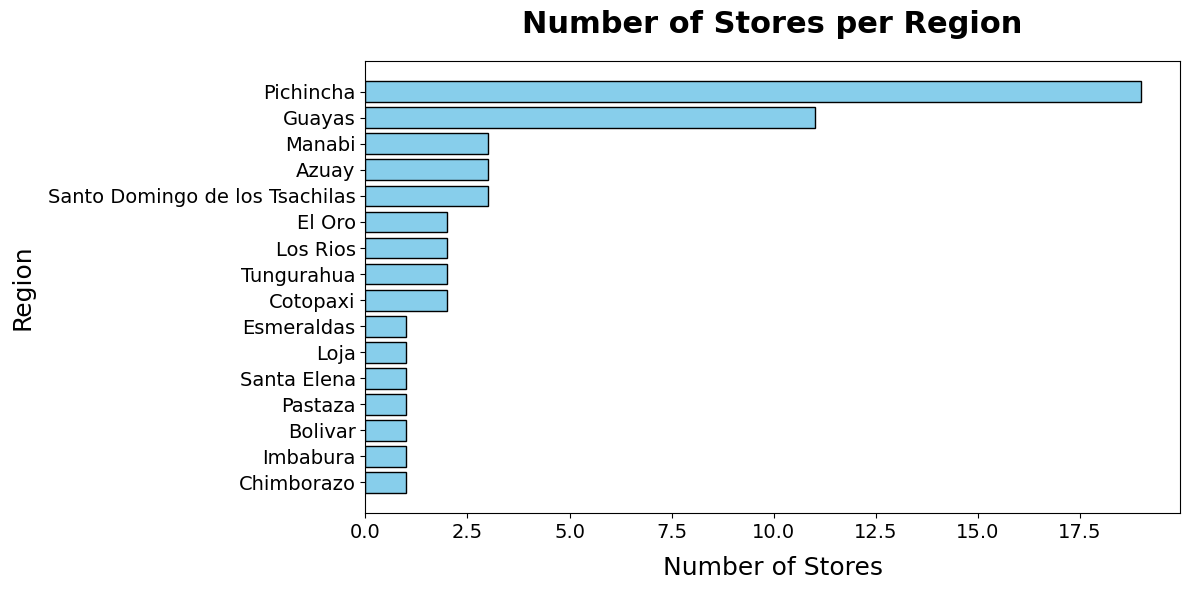

In [19]:
# Plotting the number of stores per region (state)
# Count the number of stores per region and sort in ascending order
stores_per_region = df_stores['state'].value_counts().reset_index()
stores_per_region.columns = ['Region', 'Store Count']
stores_per_region = stores_per_region.sort_values(by='Store Count', ascending=True)

# Plot the sorted data
plt.figure(figsize=(12, 6))  # Increase figure size for better readability
plt.barh(stores_per_region['Region'], stores_per_region['Store Count'], color='skyblue', edgecolor='black')  # Use horizontal bar plot
# Titles and labels with enhanced formatting
plt.title("Number of Stores per Region", fontsize=22, fontweight='bold', pad=20)
plt.xlabel("Number of Stores", fontsize=18, labelpad=10)
plt.ylabel("Region", fontsize=18, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

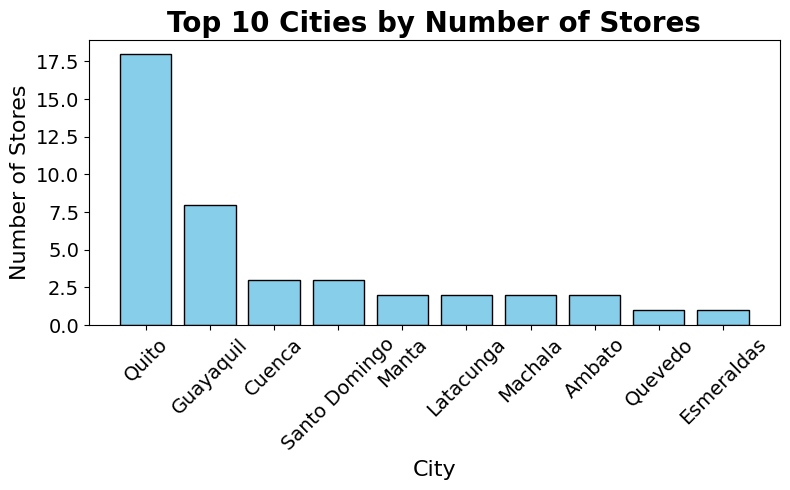

In [20]:
# Plotting the number of stores per city

# Compute the number of stores per city and select the top 10 cities
stores_per_city = df_stores['city'].value_counts().reset_index()
stores_per_city.columns = ['City', 'Store Count']
top_10_cities = stores_per_city.head(10)  # Keep only the top 10 cities

# Plot the top 10 cities
plt.figure(figsize=(8, 5))
plt.bar(top_10_cities['City'], top_10_cities['Store Count'], color='skyblue', edgecolor='black')
# Add titles and labels with appropriate formatting
plt.title("Top 10 Cities by Number of Stores", fontsize=20, fontweight='bold')
plt.xlabel("City", fontsize=16)
plt.ylabel("Number of Stores", fontsize=16)
# Adjust tick labels for better readability
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
# Ensure layout fits nicely
plt.tight_layout()
# Display the plot
plt.show()


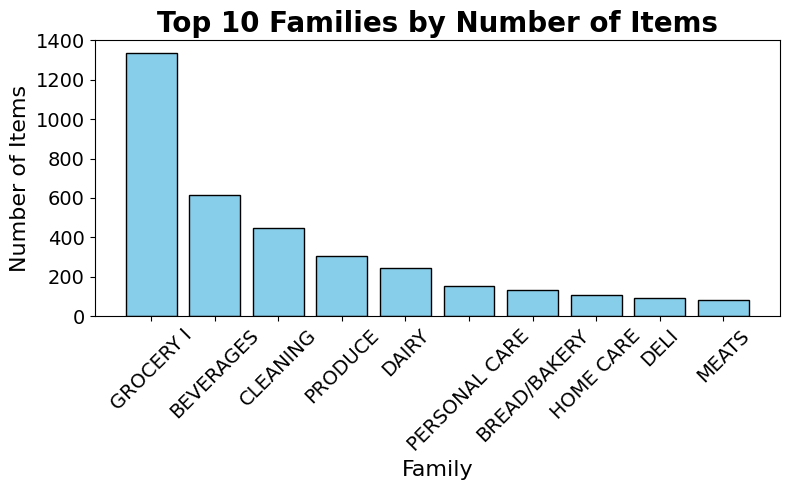

In [21]:
# Plotting the number of items per family (for top 10 families only)
# Compute the number of items per family and select the top 10 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_10_families = items_per_family.head(10)  # Keep only the top 10 families

# Plot the top 10 families
plt.figure(figsize=(8, 5))
plt.bar(top_10_families['Family'], top_10_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 10 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

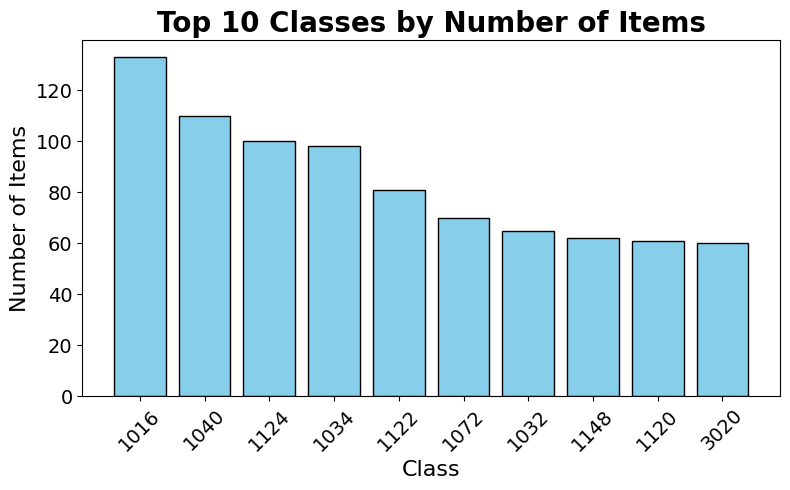

In [22]:
# Plotting the number of items per class
# Compute the number of items per class and select the top 10 classes
items_per_class = df_items['class'].value_counts().reset_index()
items_per_class.columns = ['Class', 'Item Count']
top_10_classes = items_per_class.head(10)  # Keep only the top 10 classes

# Plot the top 10 classes
plt.figure(figsize=(8, 5))
plt.bar(top_10_classes['Class'].astype(str), top_10_classes['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 10 Classes by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Class", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

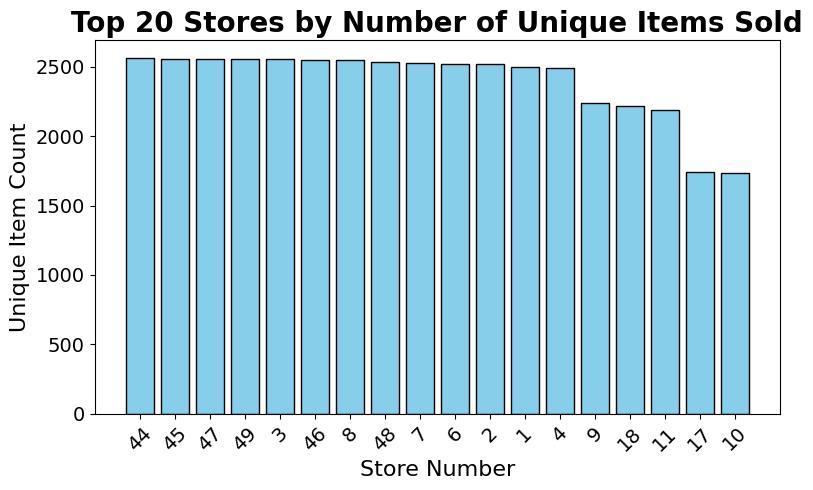

In [23]:
# Calculate the number of unique items per store in df_train
items_per_store = df_train.groupby('store_nbr')['item_nbr'].nunique().reset_index()
items_per_store.columns = ['Store Number', 'Unique Item Count']

# Select the top 10 stores by unique item count
top_20_stores = items_per_store.sort_values(by='Unique Item Count', ascending=False).head(20)
# Plot the top 10 stores
plt.figure(figsize=(8, 5))
plt.bar(top_20_stores['Store Number'].astype(str), top_20_stores['Unique Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 20 Stores by Number of Unique Items Sold", fontsize=20, fontweight='bold')
plt.xlabel("Store Number", fontsize=16)
plt.ylabel("Unique Item Count", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

## Sales Over Time (Aggregated)

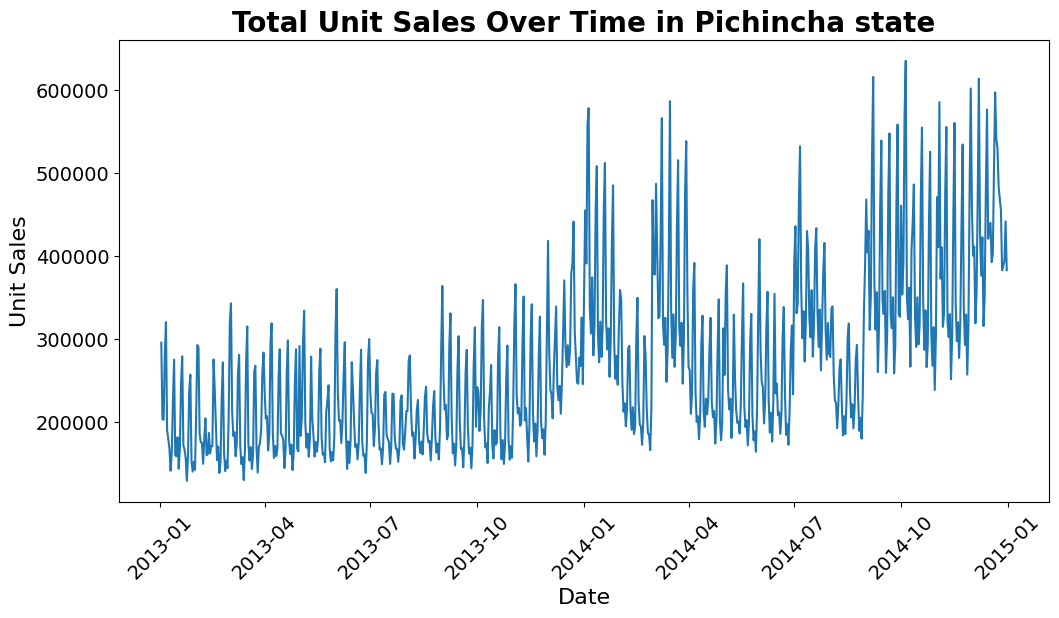

In [25]:
# Aggregating total sales by date
store_id = df_stores[df_stores['state']=='Pichincha']['store_nbr'].unique()
sales_by_date = df_train[df_train['store_nbr'].isin(store_id)].groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Pichincha state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## Sales Trend by Year and Month

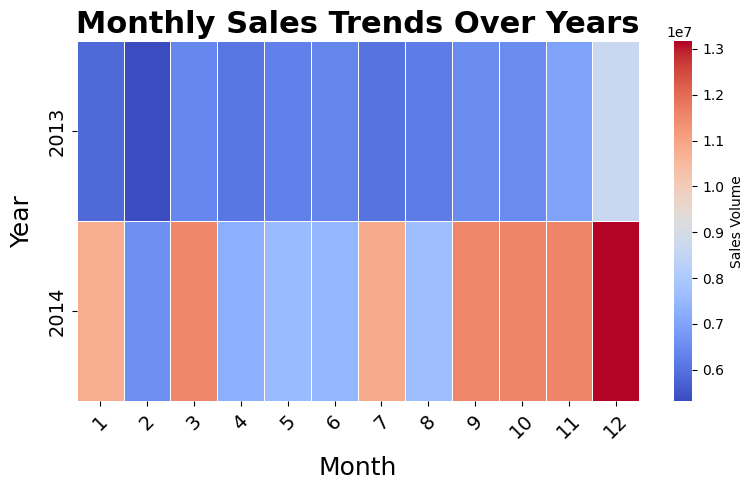

In [27]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

## Number of new items launched every month

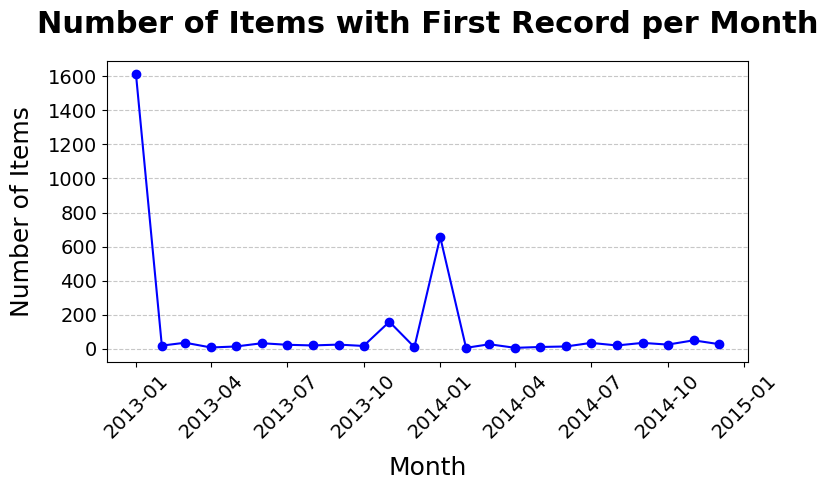

In [28]:
# Identify the first record for each item by date
df_train['date'] = pd.to_datetime(df_train['date'])  # Ensure the date column is in datetime format
first_record_per_item = df_train.groupby('item_nbr')['date'].min().reset_index()

# Extract year and month and count items for each month
first_record_per_item['YearMonth'] = first_record_per_item['date'].dt.to_period('M')
items_per_month = first_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
items_per_month['YearMonth'] = items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(items_per_month['YearMonth'], items_per_month['Item Count'], marker='o', linestyle='-', color='b')  # Line plot with markers

# Add titles and labels
plt.title('Number of Items with First Record per Month', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Number of Items', fontsize=18, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()


## Number of items discontinued every month

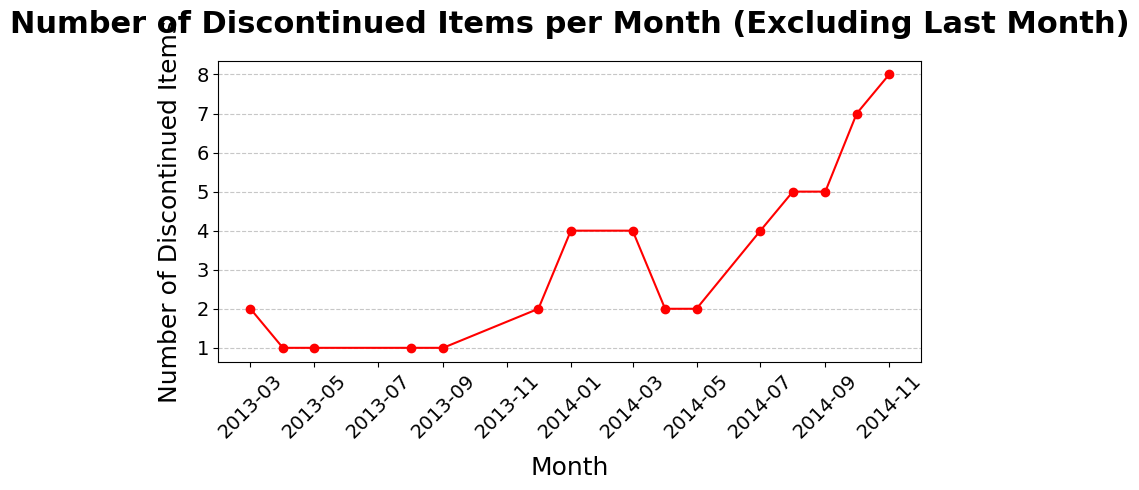

In [29]:
# Identify the last record for each item by date
df_train['date'] = pd.to_datetime(df_train['date'])  # Ensure the date column is in datetime format
last_record_per_item = df_train.groupby('item_nbr')['date'].max().reset_index()

# Extract year and month for each item's last record
last_record_per_item['YearMonth'] = last_record_per_item['date'].dt.to_period('M')

# Exclude the last month in the dataset
last_month = last_record_per_item['YearMonth'].max()
filtered_last_record_per_item = last_record_per_item[last_record_per_item['YearMonth'] != last_month]

# Count items discontinued per month (excluding the last month)
discontinued_items_per_month = filtered_last_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
discontinued_items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
discontinued_items_per_month['YearMonth'] = discontinued_items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(discontinued_items_per_month['YearMonth'], discontinued_items_per_month['Item Count'], marker='o', linestyle='-', color='r')  # Line plot with markers

# Add titles and labels
plt.title('Number of Discontinued Items per Month (Excluding Last Month)', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Number of Discontinued Items', fontsize=18, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

We can see that there are a few months, when significant number of new products is launched. However number of discontinued items is relatively small.
Discontinued items refer to products that are no longer available for sale in a store or across a supply chain. These items have effectively "exited" inventory due to various reasons and are not being replenished or sold anymore.

## Effect of Promotions on Sales

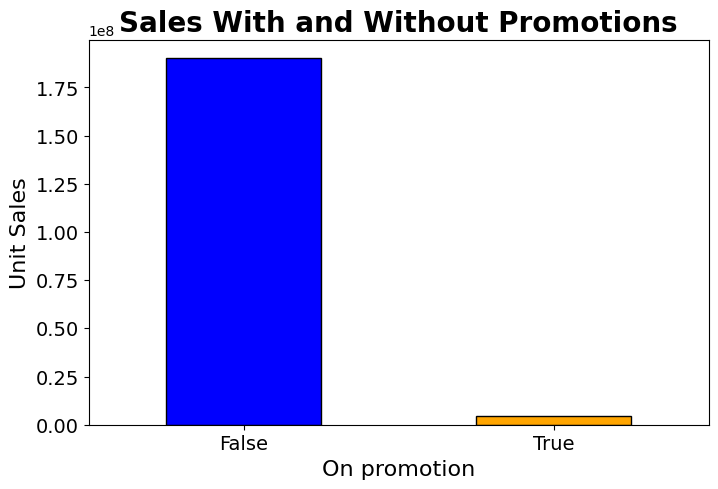

In [30]:
# Aggregating promotion and non-promotion sales
promo_sales = df_train.groupby('onpromotion')['unit_sales'].sum()

# Plotting
plt.figure(figsize=(8,5))
promo_sales.plot(kind='bar', color=['blue', 'orange'], edgecolor='black')
plt.title('Sales With and Without Promotions', fontsize=20, fontweight='bold')
plt.ylabel('Unit Sales', fontsize=16)
plt.xlabel('On promotion', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.show()

# Investigating Relationship with Oil Prices

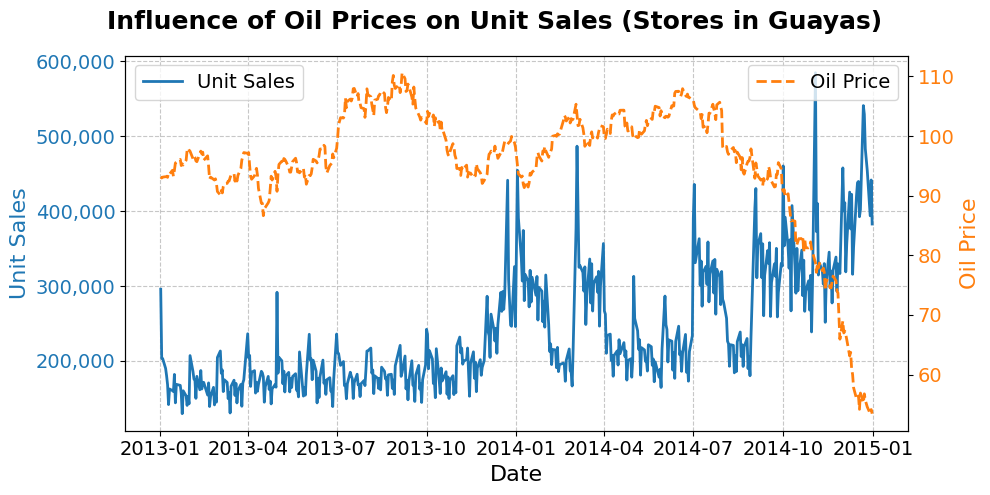

In [31]:
# Ensure datetime formats for merging and plotting
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Aggregate sales data by date (using 'unit_sales')
sales_by_date = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Merge aggregated sales with oil prices
merged_data = pd.merge(sales_by_date, df_oil, on='date', how='left')
del df_oil, sales_by_date  #clean up

# Rename columns for clarity
merged_data.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

# Drop rows where oil price is NaN
merged_data = merged_data.dropna(subset=['oil_price'])

# Plot unit sales and oil prices
fig, ax1 = plt.subplots(figsize=(10, 5))  # Bigger figure size for better readability

# Plot unit sales on the left y-axis
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Unit Sales', fontsize=16, color='tab:blue')
ax1.plot(merged_data['date'], merged_data['unit_sales'], label='Unit Sales', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Format y-axis for unit sales
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Plot oil prices on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price', fontsize=16, color='tab:orange')
ax2.plot(merged_data['date'], merged_data['oil_price'], label='Oil Price', color='tab:orange', linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)

# Add grid, titles, and legends
fig.suptitle('Influence of Oil Prices on Unit Sales (Stores in Guayas)', fontsize=18, fontweight='bold')
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)
ax1.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

In total sales where is very no direct influence of oil prices visible.

# Examining the Impact of Holidays

Holidays range: from 2012-03-02 till 2017-12-26


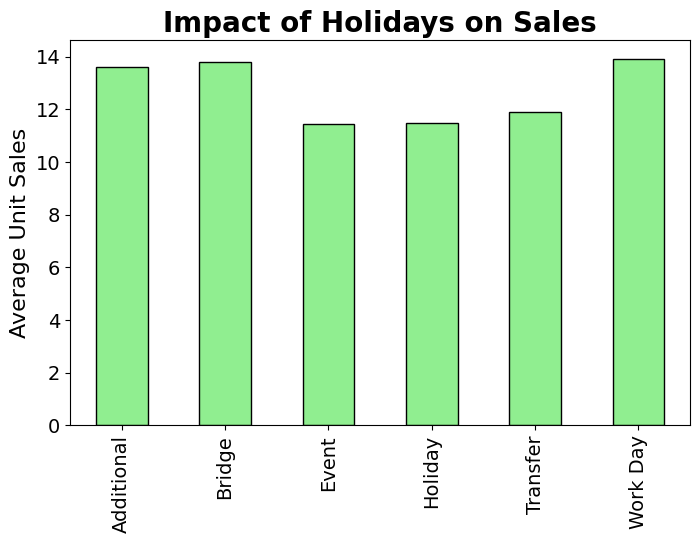

In [32]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

# Merging df_train data with holidays
df_train_holiday = pd.merge(df_train, df_holidays_events, on='date', how='left')

# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Analyzing Perishable Items

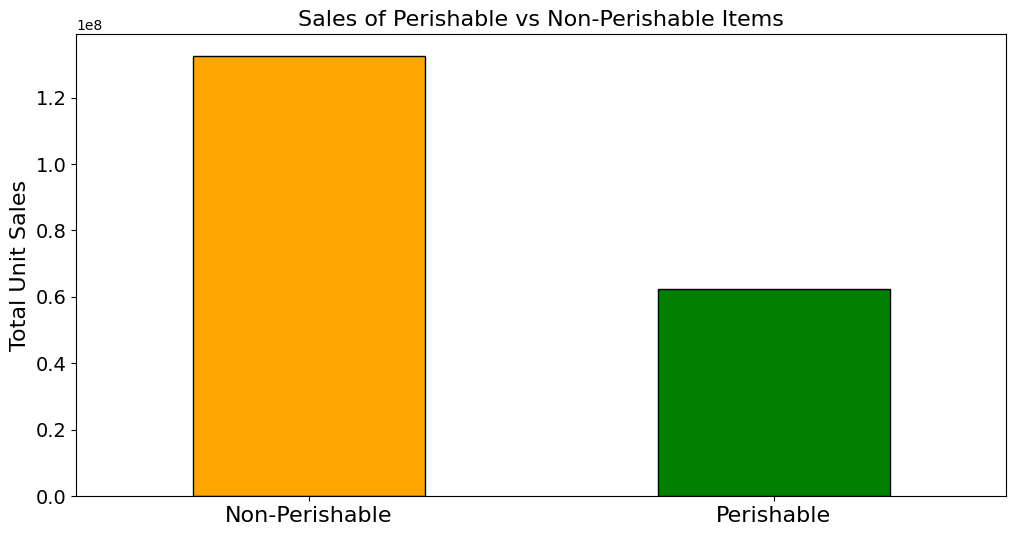

In [33]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

# Fill out missing dates with 0 sales

In [40]:
# As an example we will show how to add 0 sales only on part of the dataset
# In your project you should do the operation on the whole df_train dataset
df_train_sample = df_train.sample(1000)

In [41]:

# Convert 'date' column to datetime format
df_train_sample['date'] = pd.to_datetime(df_train_sample['date'])

# Create an empty DataFrame to store the final result
df_filled = pd.DataFrame()

# Group the data
grouped = df_train_sample.groupby(['store_nbr', 'item_nbr'])

# Iterate with a progress bar through each store and item combination
for (store, item), group in tqdm(grouped, total=grouped.ngroups):

    # Get the minimum and maximum dates in the dataset to create a full date range
    min_date = group['date'].min()
    max_date = group['date'].max()
    #print(min_date.date(), max_date.date())

    # Create a full date range covering all days between the min and max dates
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Set 'date' as index and sort by date
    group.set_index('date', inplace=True)
    group = group.sort_index()

    # Reindex to fill missing dates with 0 sales
    group = group.reindex(full_date_range, fill_value=0)

    # Keep track of the store and item number for each row
    group['store_nbr'] = store
    group['item_nbr'] = item

    # Ensure that missing sales values are filled with 0
    group['unit_sales'] = group['unit_sales'].fillna(0)

    # Append the group to the final DataFrame
    df_filled = pd.concat([df_filled, group])

# Reset the index to get 'date' back as a column
df_filled.reset_index(inplace=True)
df_filled.rename(columns={'index': 'date'}, inplace=True)

100%|██████████| 991/991 [00:03<00:00, 255.16it/s]


In [36]:
# intial dataframe didn't have rows with 0 sales
df_train_sample[df_train_sample['unit_sales'] ==0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg


In [37]:
# now we have many rows with 0 sales
df_filled[df_filled['unit_sales'] ==0]

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
174,2013-04-12,0,4,258411,0.0,0,0,0,0,0,0.0
175,2013-04-13,0,4,258411,0.0,0,0,0,0,0,0.0
176,2013-04-14,0,4,258411,0.0,0,0,0,0,0,0.0
177,2013-04-15,0,4,258411,0.0,0,0,0,0,0,0.0
178,2013-04-16,0,4,258411,0.0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4391,2014-12-19,0,49,1079254,0.0,0,0,0,0,0,0.0
4392,2014-12-20,0,49,1079254,0.0,0,0,0,0,0,0.0
4393,2014-12-21,0,49,1079254,0.0,0,0,0,0,0,0.0
4394,2014-12-22,0,49,1079254,0.0,0,0,0,0,0,0.0
